In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/20.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/6.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/5.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/8.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/30.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/38.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/33.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/10.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/35.jpg
/kaggle/input/cotton-plant-disease/Cotton plant disease/Cotton plant disease/Aphids edited/9.jpg
/kaggle/input/cotton-pla

In [30]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Set the main directory where the data folders are located
data_dir = "/kaggle/input/cotton-plant-disease/Main dataset-20230209T170929Z-001/Main dataset"

# Define the parameters for image preprocessing and data augmentation
image_size = (128, 128)
batch_size = 32

# Create ImageDataGenerator instances for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

# Generate training dataset from the images in the subfolders
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Generate validation dataset from the images in the subfolders
val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2495 images belonging to 6 classes.
Found 623 images belonging to 6 classes.


In [33]:
vgg16_model = VGG16(weights='/kaggle/input/vgg-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False,
                    input_shape=(128, 128, 3))


In [34]:
# Freeze the base model layers
for layer in vgg16_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = Flatten()(vgg16_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

In [38]:
# Create the final model
model = Model(inputs=vgg16_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [41]:
# Define callbacks for ModelCheckpoint and ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('vgg16_cotton_disease.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with the callbacks
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[model_checkpoint, reduce_lr])


Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 0.9593 - accuracy: 0.6473
Epoch 1: val_accuracy improved from -inf to 0.82344, saving model to vgg16_cotton_disease.h5
78/78 [==============================] - 294s 4s/step - loss: 0.9593 - accuracy: 0.6473 - val_loss: 0.5079 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.8257
Epoch 2: val_accuracy improved from 0.82344 to 0.86035, saving model to vgg16_cotton_disease.h5
78/78 [==============================] - 292s 4s/step - loss: 0.4887 - accuracy: 0.8257 - val_loss: 0.3916 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8581
Epoch 3: val_accuracy improved from 0.86035 to 0.90369, saving model to vgg16_cotton_disease.h5
78/78 [==============================] - 291s 4s/step - loss: 0.3985 - accuracy: 0.8581 - val_loss: 0.2768 - val_accuracy: 0.9037 - lr: 0.0010
Epoc

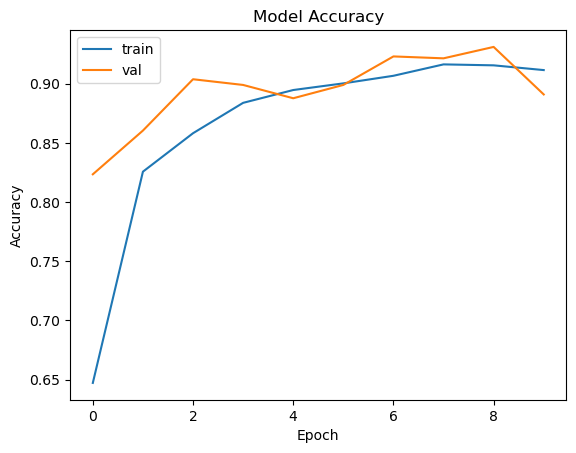

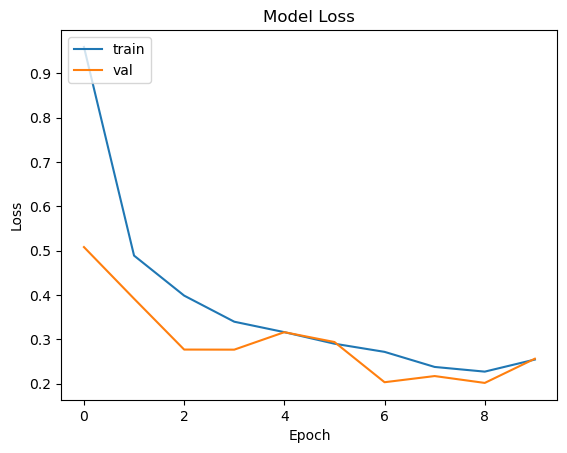

In [43]:
# Save the training history to a file
np.save('vgg16_training_history.npy', history.history)

# Plot training and validation curves
plot_curves(history)



20/20 [==============================] - 58s 3s/step
Confusion Matrix:
[[11 17 12 22 19 23]
 [11 18 21 17 18 19]
 [20 24 13 11 18 18]
 [14 14 16 11 21 28]
 [19 10 15 13 23 24]
 [13 18 14 11 18 29]]


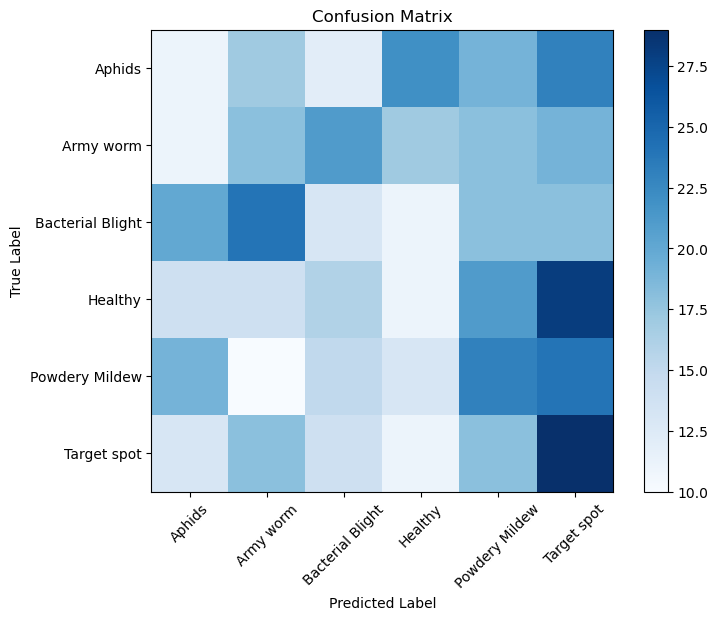

In [45]:
#Get the true labels and predictions for the validation set
true_labels = val_data.classes
val_data.reset()
predictions = model.predict(val_data)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_data.class_indices))
plt.xticks(tick_marks, val_data.class_indices, rotation=45)
plt.yticks(tick_marks, val_data.class_indices)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 [==============================] - 3s 3s/step


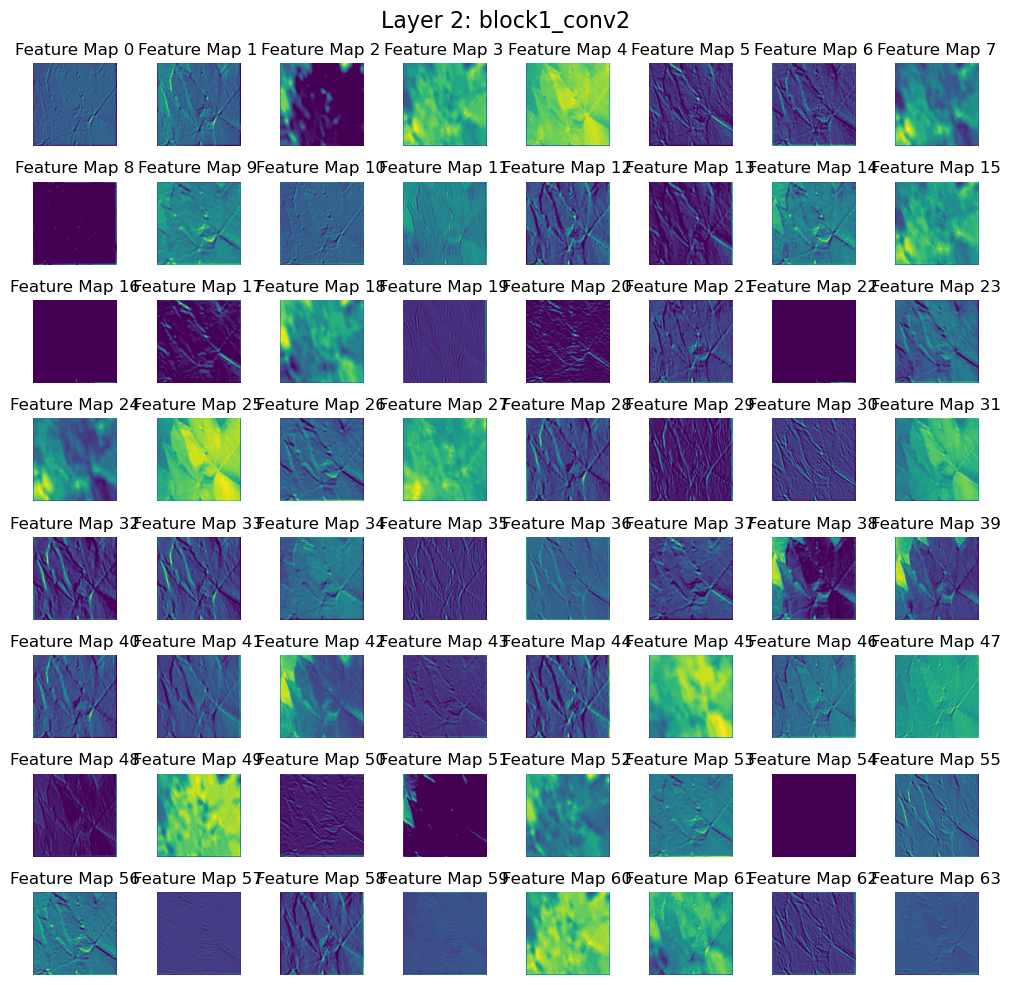

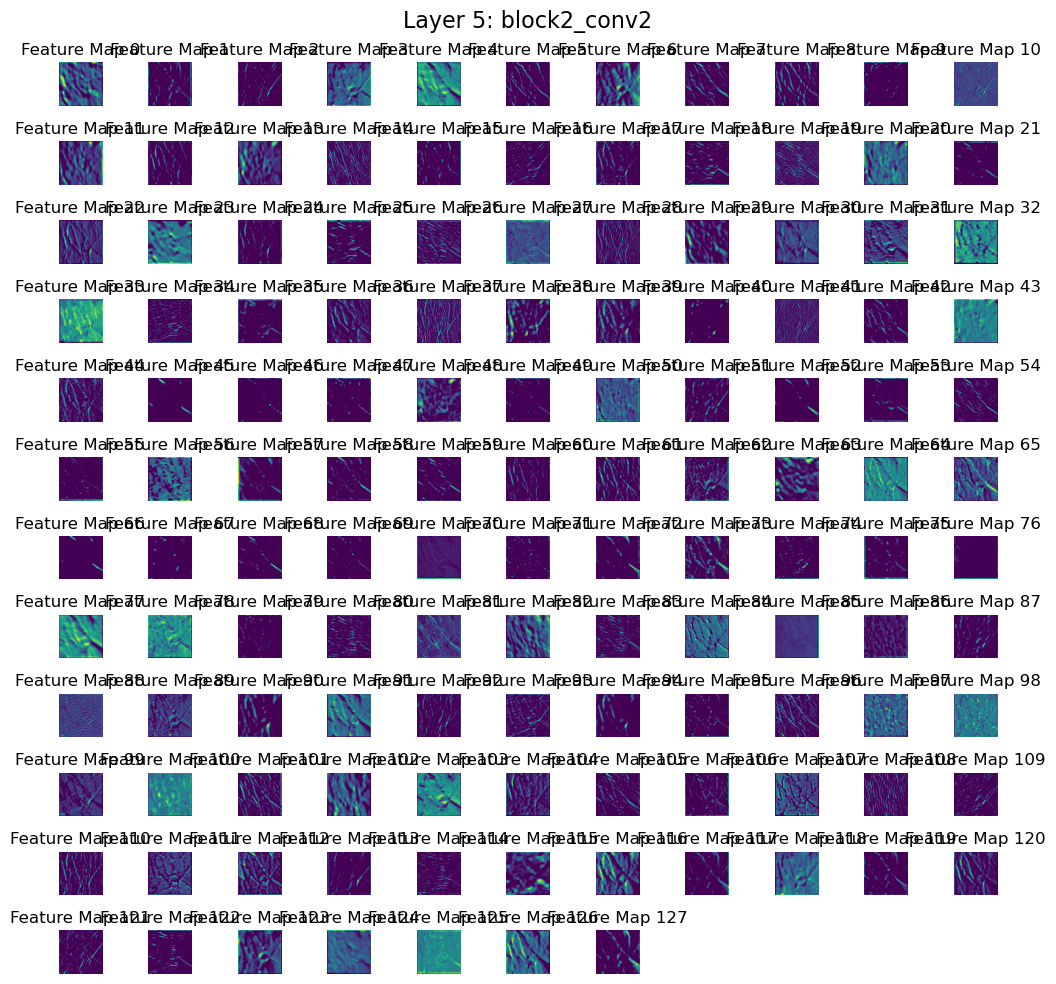

In [48]:
import math

def visualize_intermediate_outputs(model, sample_image, layer_indices):
    intermediate_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
    intermediate_outputs = intermediate_model.predict(sample_image)

    for i in layer_indices:
        layer_output = intermediate_outputs[i]
        num_feature_maps = layer_output.shape[3]
        rows = int(math.ceil(math.sqrt(num_feature_maps)))
        cols = int(math.ceil(num_feature_maps / rows))

        plt.figure(figsize=(10, 10))
        plt.suptitle(f"Layer {i}: {model.layers[i].name}", fontsize=16)

        for j in range(num_feature_maps):
            plt.subplot(rows, cols, j + 1)
            feature_map = layer_output[0, :, :, j]
            plt.imshow(feature_map, cmap='viridis')
            plt.title(f"Feature Map {j}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize intermediate outputs for specific layers (e.g., layers 2 and 5)
sample_image, _ = next(val_data)
visualize_intermediate_outputs(model, sample_image, layer_indices=[2, 5])


In [49]:
# Assuming your model is already trained, and you have defined 'val_data' as the validation data generator

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(val_data)

# Print the accuracy
print(f"Model Accuracy: {accuracy * 100:.2f}%")


20/20 [==============================] - 58s 3s/step - loss: 0.2491 - accuracy: 0.9037
Model Accuracy: 90.37%


In [50]:
# Load the trained model
model = tf.keras.models.load_model('vgg16_cotton_disease.h5')

In [51]:
# Load and preprocess the new image
new_image_path = '/kaggle/input/new-images/powdery nildew.jpeg'  # Replace 'path_to_your_new_image.jpg' with the actual path to your new image
new_image = tf.keras.preprocessing.image.load_img(new_image_path, target_size=image_size)
new_image_array = tf.keras.preprocessing.image.img_to_array(new_image)
new_image_array = new_image_array / 255.0  # Normalize pixel values to [0, 1]
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

In [52]:
# Make prediction
prediction = model.predict(new_image_array)
predicted_class_index = np.argmax(prediction[0])

1/1 [==============================] - 0s 275ms/step


In [53]:
# Get the class indices from the train_data object
class_indices = train_data.class_indices

# Create a list of class labels by sorting the class names based on their indices
class_labels = [class_name for class_name, index in sorted(class_indices.items(), key=lambda x: x[1])]

# Print the class labels
print(class_labels)


['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


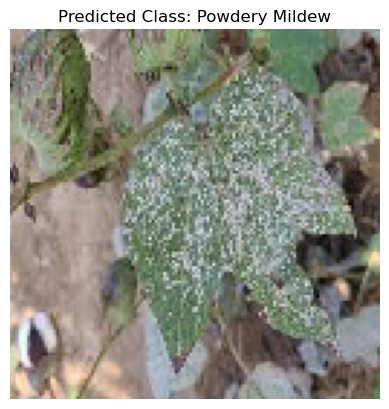

In [54]:
# Display the new image
plt.imshow(new_image)
plt.axis('off')

# Display the predicted class label
predicted_class_label = class_labels[predicted_class_index]
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()

In [55]:
# Load and preprocess the new image
new_image_path = '/kaggle/input/imagess/Leaves-of-Cotton.jpg'  # Replace 'path_to_your_new_image.jpg' with the actual path to your new image
new_image = tf.keras.preprocessing.image.load_img(new_image_path, target_size=image_size)
new_image_array = tf.keras.preprocessing.image.img_to_array(new_image)
new_image_array = new_image_array / 255.0  # Normalize pixel values to [0, 1]
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

In [56]:
# Make prediction
prediction = model.predict(new_image_array)
predicted_class_index = np.argmax(prediction[0])

1/1 [==============================] - 0s 118ms/step


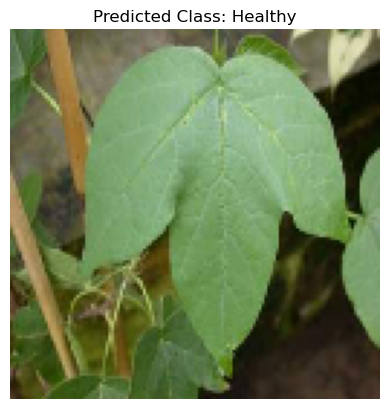

In [57]:
# Display the new image
plt.imshow(new_image)
plt.axis('off')

# Display the predicted class label
predicted_class_label = class_labels[predicted_class_index]
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()

In [59]:
# Load and preprocess the new image
new_image_path = '/kaggle/input/imagess/aphid-cotton-6.jpg'  # Replace 'path_to_your_new_image.jpg' with the actual path to your new image
new_image = tf.keras.preprocessing.image.load_img(new_image_path, target_size=image_size)
new_image_array = tf.keras.preprocessing.image.img_to_array(new_image)
new_image_array = new_image_array / 255.0  # Normalize pixel values to [0, 1]
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

In [60]:
# Make prediction
prediction = model.predict(new_image_array)
predicted_class_index = np.argmax(prediction[0])

1/1 [==============================] - 0s 123ms/step


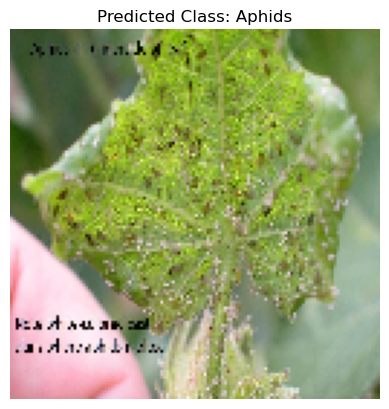

In [61]:
# Display the new image
plt.imshow(new_image)
plt.axis('off')

# Display the predicted class label
predicted_class_label = class_labels[predicted_class_index]
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()